In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
!pip install sklearn-ts==0.0.5

Load data

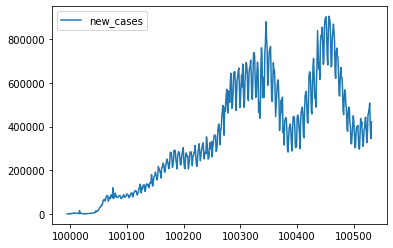

In [3]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

In [4]:
# prepare features
features = ['year', 'month', f'{h}_lag', f'{h}_lag_rolling', 'dayofweek', 'intercept', 'trend', 'log']
categorical_features = ['year', 'month', 'dayofweek']
numerical_features = [f'{h}_lag', f'{h}_lag_rolling', 'intercept', 'trend', 'log']

dataset['date'] = pd.to_datetime(dataset['date'])
dataset.index = dataset['date']
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year
dataset['dayofweek'] = dataset['date'].dt.dayofweek
dataset[f'{h}_lag'] = dataset[target].shift(h)
dataset[f'rolling_{target}'] = dataset[target].rolling(window=h).mean()
dataset[f'{h}_lag_rolling'] = dataset[f'rolling_{target}'].shift(h)
dataset['intercept'] = 1
dataset['trend'] = range(dataset.shape[0])
dataset['log'] = dataset['trend'].apply(lambda x: math.log(x+1))
dataset = dataset[['date', target] + numerical_features +categorical_features]
dataset = dataset.dropna()

In [5]:
from sklearn_ts.validator import check_model

In [6]:
! pip install prophet
from prophet import Prophet

     |████████████████████████████████| 71kB 4.8MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 184kB 17.2MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639913 sha256=f07b3929634c6c2b9e9460ec882c02095059bb48530fa4dcb86ae716592b4655
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [7]:
df = dataset.copy()
df['ds'] = df['date']
df['y'] = df[target]
m = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.add_regressor(f'{h}_lag_rolling')
m.fit(df)

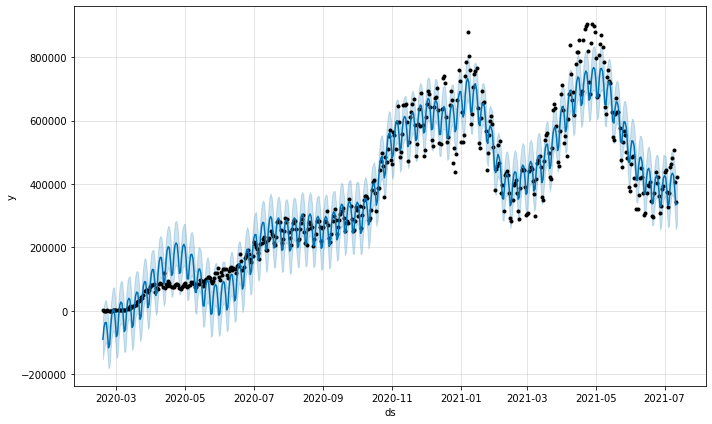

In [8]:
#future = m.make_future_dataframe(periods=14)
forecast = m.predict(df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

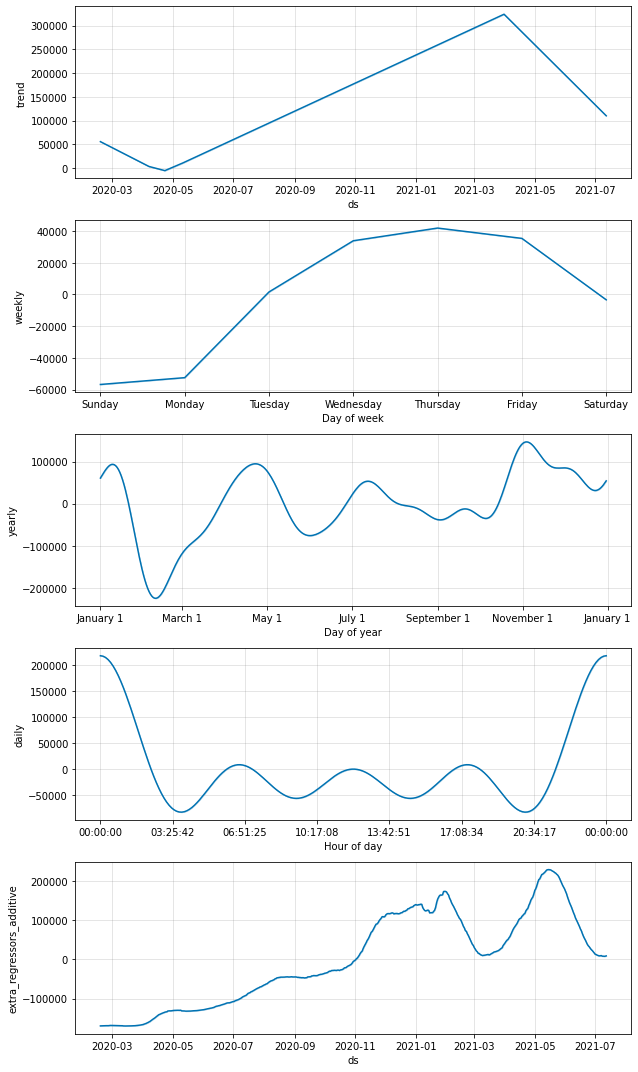

In [9]:
fig = m.plot_components(forecast)

In [12]:
from prophet.utilities import regressor_coefficients

regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,14_lag_rolling,additive,349478.987559,0.488569,0.488569,0.488569


In [13]:
from sklearn.base import BaseEstimator, RegressorMixin
from prophet.utilities import regressor_coefficients


class ProphetRegressor(BaseEstimator, RegressorMixin):
    # https://facebook.github.io/prophet/docs/quick_start.html#python-api

    def __init__(self, target='new_cases', features=['date', f'{h}_lag_rolling'], regressors=[f'{h}_lag_rolling']):
        self.target = target
        self.features = features
        self.regressors = regressors

        self.model = None
        self.predictions= None

    def fit(self, X, y):
        df = pd.DataFrame(X, columns=self.features)

        df['ds'] = df['date']
        df['y'] = y.values

        m = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
        for regressor in self.regressors:
            m.add_regressor(regressor)
        m.fit(df)

        self.model = m
        self.feature_importances_ = [None] + regressor_coefficients(m)['coef'].tolist()  # place for date
        return self

    def predict(self, X):
        df = pd.DataFrame(X, columns=self.features)
        df['ds'] = df['date']
        predictions = self.model.predict(df)
        self.predictions = predictions[['ds', 'yhat_lower', 'yhat_upper']].rename(columns={'yhat_lower': 'pi_lower', 'yhat_upper': 'pi_upper'})
        return predictions['yhat'].values

    def get_params(self, deep=True):
        return {"target": self.target, 'regressors': self.regressors, 'features': self.features}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

{'regressor__regressors': ['14_lag_rolling']}

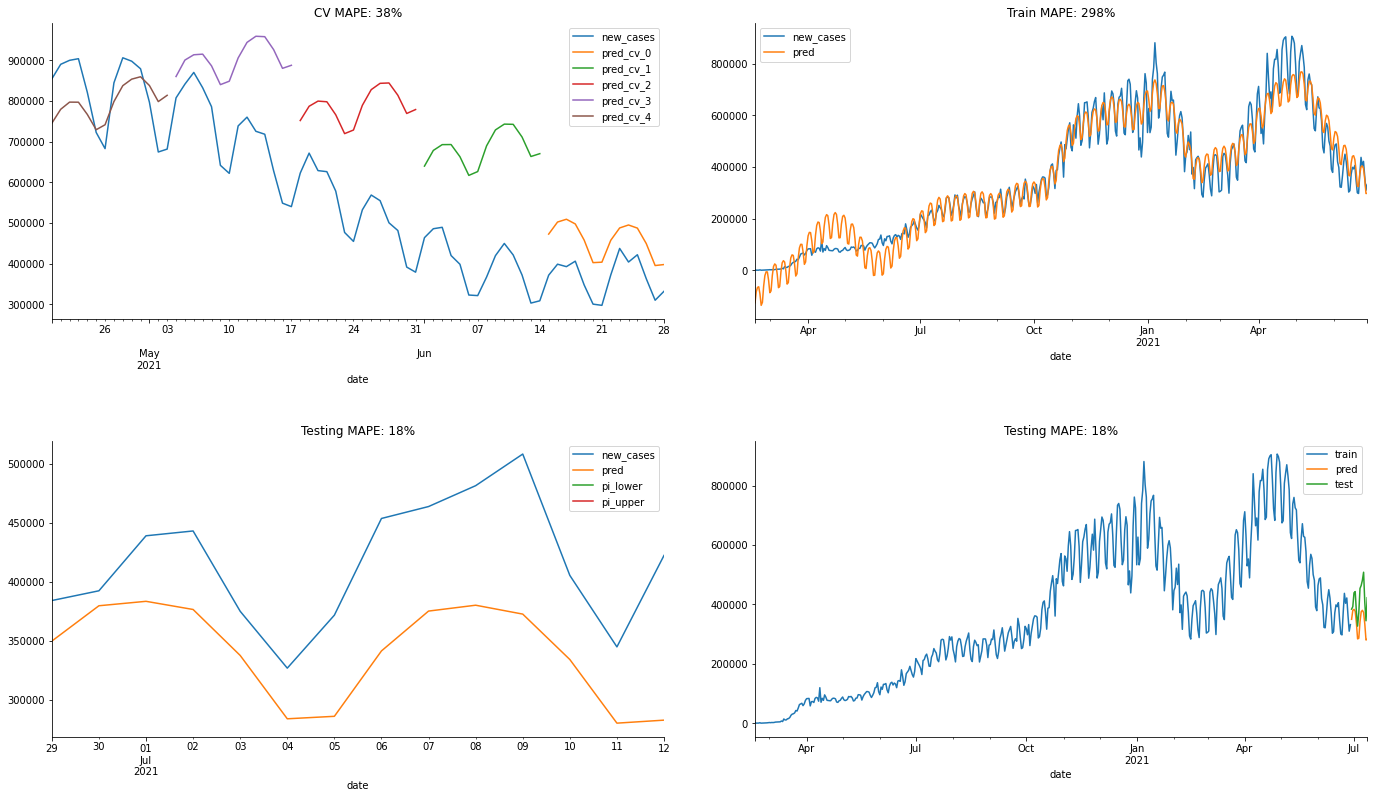

In [14]:
params = {'regressors': [[f'{h}_lag_rolling']]}
regressor = ProphetRegressor()

results = check_model(regressor, params, dataset, features=['date', f'{h}_lag_rolling'])
results['best_params']

In [15]:
results['model'].named_steps['regressor'].predictions

,ds,pi_lower,pi_upper
0,2020-02-18,-196276.227969,-52689.517346
1,2020-02-19,-156722.043394,-9765.846504
2,2020-02-20,-144300.553474,-912.888258
3,2020-02-21,-131963.258583,7819.176664
4,2020-02-22,-160706.861522,-22674.572205
...,...,...,...
492,2021-06-24,327683.623333,472228.284868
493,2021-06-25,325424.604801,467335.737042
494,2021-06-26,287322.289541,425251.667667
495,2021-06-27,222758.266000,371618.147185
